                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Total counts of each label:
0    130908
1     89117
Name: label, dtype: int64


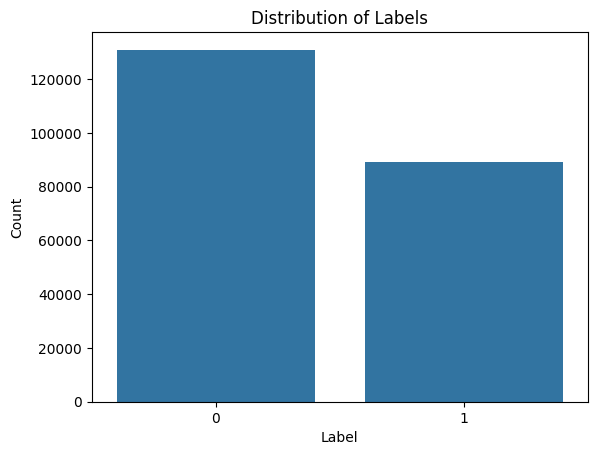

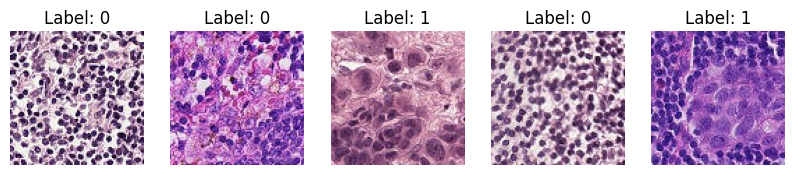

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

# Load train labels
train_labels = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')

# Display the first few rows of the train_labels dataframe
print(train_labels.head())

# Count the number of labels
label_counts = train_labels['label'].value_counts()
print("Total counts of each label:")
print(label_counts)

# Plot the distribution of labels using the counts
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Load a few sample images and display them
sample_images = train_labels.sample(5)['id'].values
plt.figure(figsize=(10, 5))
for i, img_id in enumerate(sample_images):
    img_path = os.path.join('histopathologic-cancer-detection/train/', f'{img_id}.tif')
    img = Image.open(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f'Label: {train_labels[train_labels["id"] == img_id]["label"].values[0]}')
    plt.axis('off')
plt.show()


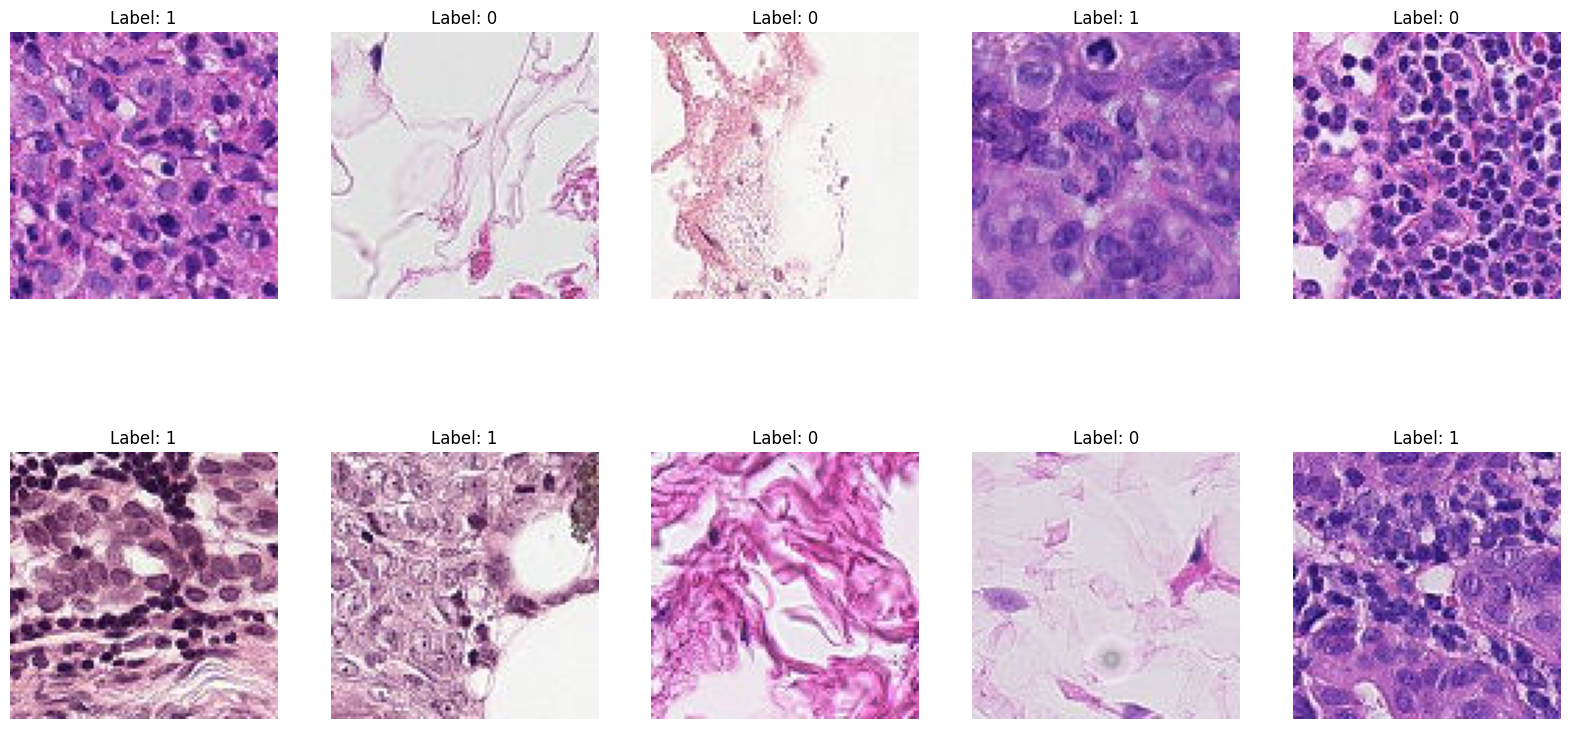

Unique image sizes: [[96 96]]


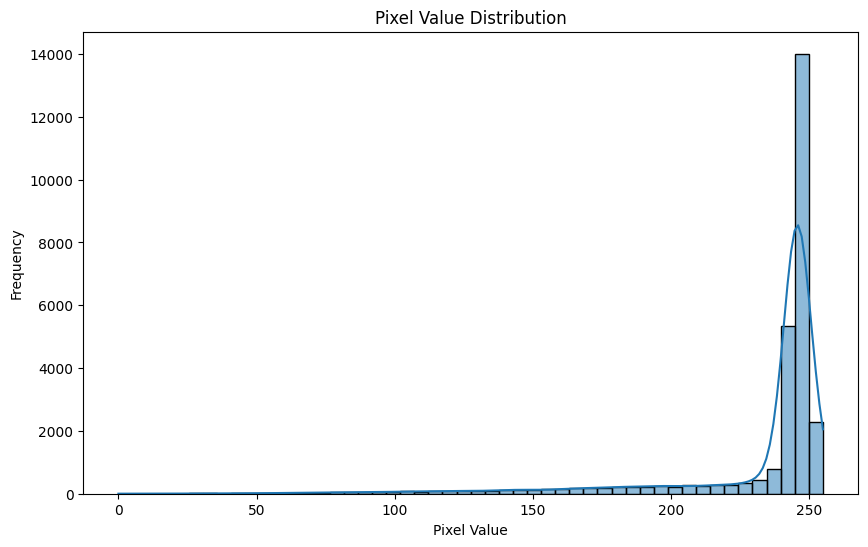

In [6]:
# Load a few sample images and display them
def load_image(img_id, folder='/Users/samuel.lausten/Documents/CU_Boulder/deep_learning/histo_cancer_detection/histopathologic-cancer-detection/train'):
    img_path = os.path.join(folder, f'{img_id}.tif')
    try:
        return Image.open(img_path)
    except FileNotFoundError:
        print(f'File not found: {img_path}')
        return None

sample_images = train_labels.sample(10)
plt.figure(figsize=(20, 10))
for i, (img_id, label) in enumerate(zip(sample_images['id'], sample_images['label'])):
    img = load_image(img_id)
    if img:
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')
plt.show()

# Check for image size consistency
img_sizes = []
for img_id in train_labels['id'].sample(100):  # Checking a sample of 100 images
    img = load_image(img_id)
    if img:
        img_sizes.append(img.size)

# Convert to numpy array for analysis
img_sizes = np.array(img_sizes)
print(f'Unique image sizes: {np.unique(img_sizes, axis=0)}')

# Pixel value distribution
img_id = train_labels['id'].iloc[0]
img = load_image(img_id)
if img:
    img_array = np.array(img)
    plt.figure(figsize=(10, 6))
    sns.histplot(img_array.flatten(), bins=50, kde=True)
    plt.title('Pixel Value Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()


## Step 3: Model Building and Training


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import pandas as pd
from PIL import Image
import os
import numpy as np
from tqdm import tqdm

# Paths
train_dir = '/Users/samuel.lausten/Documents/CU_Boulder/deep_learning/histo_cancer_detection/histopathologic-cancer-detection/train'
test_dir = '/Users/samuel.lausten/Documents/CU_Boulder/deep_learning/histo_cancer_detection/histopathologic-cancer-detection/test'
img_size = 96
batch_size = 32
num_epochs = 10

# Load train labels
train_labels = pd.read_csv('/Users/samuel.lausten/Documents/CU_Boulder/deep_learning/histo_cancer_detection/histopathologic-cancer-detection/train_labels.csv')

# Define a custom dataset
class HistopathologicCancerDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_id = self.dataframe.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, f'{img_id}.tif')
        image = Image.open(img_path).convert('RGB')
        label = int(self.dataframe.iloc[idx, 1])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define a custom dataset for test images
class HistopathologicCancerTestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_ids = os.listdir(img_dir)

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.img_dir, img_id)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, img_id

# Data transforms
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # Ensure this transform gets a PIL image
    transforms.Lambda(lambda img: torch.as_tensor(np.array(img).astype('float32')).permute(2, 0, 1) / 255)  # Convert PIL image to tensor
])

# Create datasets and dataloaders
train_dataset = HistopathologicCancerDataset(train_labels, train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = HistopathologicCancerTestDataset(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Debugging: Check the first batch
first_batch = next(iter(train_loader))
print(f'First batch - images shape: {first_batch[0].shape}, labels shape: {first_batch[1].shape}')

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 12 * 12)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.float().to(device).view(-1, 1)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss/len(train_loader))
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

print('Finished Training')

# Make predictions on the test set
model.eval()
predictions = []
with torch.no_grad():
    for images, img_ids in tqdm(test_loader, desc='Testing', unit='batch'):
        images = images.to(device)
        outputs = model(images)
        preds = outputs.cpu().detach().numpy().flatten()  # Explicit conversion
        for img_id, pred in zip(img_ids, preds):
            predictions.append((img_id, pred))

# Save predictions to CSV
predictions_df = pd.DataFrame(predictions, columns=['id', 'label'])
predictions_df['label'] = predictions_df['label'].apply(lambda x: 1 if x > 0.5 else 0)  # Apply threshold
predictions_df.to_csv('predictions.csv', index=False)

print('Predictions saved to predictions.csv')


First batch - images shape: torch.Size([32, 3, 96, 96]), labels shape: torch.Size([32])


Epoch 1/10: 100%|██████████| 6876/6876 [16:27<00:00,  6.97batch/s, loss=0.381] 


Epoch [1/10], Loss: 0.3811


Epoch 2/10: 100%|██████████| 6876/6876 [16:21<00:00,  7.01batch/s, loss=0.289] 


Epoch [2/10], Loss: 0.2894


Epoch 3/10: 100%|██████████| 6876/6876 [16:17<00:00,  7.04batch/s, loss=0.25]  


Epoch [3/10], Loss: 0.2503


Epoch 4/10: 100%|██████████| 6876/6876 [47:49<00:00,  2.40batch/s, loss=0.228]     


Epoch [4/10], Loss: 0.2282


Epoch 5/10: 100%|██████████| 6876/6876 [1:39:33<00:00,  1.15batch/s, loss=0.21]       


Epoch [5/10], Loss: 0.2102


Epoch 6/10: 100%|██████████| 6876/6876 [16:12<00:00,  7.07batch/s, loss=0.197] 


Epoch [6/10], Loss: 0.1974


Epoch 7/10: 100%|██████████| 6876/6876 [16:14<00:00,  7.06batch/s, loss=0.186] 


Epoch [7/10], Loss: 0.1864


Epoch 8/10: 100%|██████████| 6876/6876 [16:15<00:00,  7.05batch/s, loss=0.177] 


Epoch [8/10], Loss: 0.1767


Epoch 9/10: 100%|██████████| 6876/6876 [26:12<00:00,  4.37batch/s, loss=0.167]   


Epoch [9/10], Loss: 0.1670


Epoch 10/10: 100%|██████████| 6876/6876 [16:11<00:00,  7.08batch/s, loss=0.158] 


Epoch [10/10], Loss: 0.1582
Finished Training


Testing: 100%|██████████| 1796/1796 [02:07<00:00, 14.07batch/s]

Predictions saved to predictions.csv


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import pandas as pd
from PIL import Image
import os
import numpy as np
from tqdm import tqdm

# Paths
train_dir = '/Users/samuel.lausten/Documents/CU_Boulder/deep_learning/histo_cancer_detection/histopathologic-cancer-detection/train'
test_dir = '/Users/samuel.lausten/Documents/CU_Boulder/deep_learning/histo_cancer_detection/histopathologic-cancer-detection/test'
img_size = 96
batch_size = 32
num_epochs = 10

# Load train labels
train_labels = pd.read_csv('/Users/samuel.lausten/Documents/CU_Boulder/deep_learning/histo_cancer_detection/histopathologic-cancer-detection/train_labels.csv')

# Define a custom dataset
class HistopathologicCancerDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_id = self.dataframe.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, f'{img_id}.tif')
        image = Image.open(img_path).convert('RGB')
        label = int(self.dataframe.iloc[idx, 1])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define a custom dataset for test images
class HistopathologicCancerTestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_ids = os.listdir(img_dir)

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.img_dir, img_id)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, img_id

# Data transforms
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # Ensure this transform gets a PIL image
    transforms.Lambda(lambda img: torch.as_tensor(np.array(img).astype('float32')).permute(2, 0, 1) / 255)  # Convert PIL image to tensor
])

# Create datasets and dataloaders
train_dataset = HistopathologicCancerDataset(train_labels, train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = HistopathologicCancerTestDataset(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Debugging: Check the first batch
first_batch = next(iter(train_loader))
print(f'First batch - images shape: {first_batch[0].shape}, labels shape: {first_batch[1].shape}')

# Define the simplified AlexNet model
class SimplifiedAlexNet(nn.Module):
    def __init__(self, num_classes=1):
        super(SimplifiedAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x

# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimplifiedAlexNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Reduced learning rate

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.float().to(device).view(-1, 1)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss/len(train_loader))
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

print('Finished Training')

# Make predictions on the test set
model.eval()
predictions = []
with torch.no_grad():
    for images, img_ids in tqdm(test_loader, desc='Testing', unit='batch'):
        images = images.to(device)
        outputs = model(images)
        preds = outputs.cpu().detach().numpy().flatten()  # Explicit conversion
        for img_id, pred in zip(img_ids, preds):
            predictions.append((img_id, pred))

# Save predictions to CSV
predictions_df = pd.DataFrame(predictions, columns=['id', 'label'])
predictions_df['label'] = predictions_df['label'].apply(lambda x: 1 if x > 0.5 else 0)  # Apply threshold
predictions_df.to_csv('alex_net_predictions.csv', index=False)

print('Predictions saved to predictions.csv')


First batch - images shape: torch.Size([32, 3, 96, 96]), labels shape: torch.Size([32])


Epoch 1/10: 100%|██████████| 6876/6876 [15:23<00:00,  7.45batch/s, loss=0.441] 


Epoch [1/10], Loss: 0.4410


Epoch 2/10: 100%|██████████| 6876/6876 [15:18<00:00,  7.49batch/s, loss=0.362] 


Epoch [2/10], Loss: 0.3622


Epoch 3/10: 100%|██████████| 6876/6876 [15:16<00:00,  7.50batch/s, loss=0.326] 


Epoch [3/10], Loss: 0.3263


Epoch 4/10: 100%|██████████| 6876/6876 [15:13<00:00,  7.53batch/s, loss=0.293] 


Epoch [4/10], Loss: 0.2930


Epoch 5/10: 100%|██████████| 6876/6876 [15:14<00:00,  7.52batch/s, loss=0.266] 


Epoch [5/10], Loss: 0.2659


Epoch 6/10: 100%|██████████| 6876/6876 [15:12<00:00,  7.53batch/s, loss=0.239] 


Epoch [6/10], Loss: 0.2392


Epoch 7/10: 100%|██████████| 6876/6876 [15:13<00:00,  7.53batch/s, loss=0.217] 


Epoch [7/10], Loss: 0.2168


Epoch 8/10: 100%|██████████| 6876/6876 [15:12<00:00,  7.53batch/s, loss=0.193] 


Epoch [8/10], Loss: 0.1931


Epoch 9/10: 100%|██████████| 6876/6876 [15:22<00:00,  7.46batch/s, loss=0.173] 


Epoch [9/10], Loss: 0.1728


Epoch 10/10: 100%|██████████| 6876/6876 [15:15<00:00,  7.51batch/s, loss=0.153] 


Epoch [10/10], Loss: 0.1532
Finished Training


Testing: 100%|██████████| 1796/1796 [01:38<00:00, 18.33batch/s]


Predictions saved to predictions.csv


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms
import pandas as pd
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
from collections import Counter

# Paths
train_dir = '/Users/samuel.lausten/Documents/CU_Boulder/deep_learning/histo_cancer_detection/histopathologic-cancer-detection/train'
test_dir = '/Users/samuel.lausten/Documents/CU_Boulder/deep_learning/histo_cancer_detection/histopathologic-cancer-detection/test'
img_size = 96
batch_size = 64
num_epochs = 20

# Load train labels
train_labels = pd.read_csv('/Users/samuel.lausten/Documents/CU_Boulder/deep_learning/histo_cancer_detection/histopathologic-cancer-detection/train_labels.csv')

# Define a custom dataset
class HistopathologicCancerDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_id = self.dataframe.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, f'{img_id}.tif')
        image = Image.open(img_path).convert('RGB')
        label = int(self.dataframe.iloc[idx, 1])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define a custom dataset for test images
class HistopathologicCancerTestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_ids = os.listdir(img_dir)

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.img_dir, img_id)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, img_id

# Data transforms with augmentation
transform_train = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.Lambda(lambda img: torch.as_tensor(np.array(img).astype('float32')).permute(2, 0, 1) / 255)
])

transform_test = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Lambda(lambda img: torch.as_tensor(np.array(img).astype('float32')).permute(2, 0, 1) / 255)
])

# Create datasets
train_dataset = HistopathologicCancerDataset(train_labels, train_dir, transform=transform_train)
test_dataset = HistopathologicCancerTestDataset(test_dir, transform=transform_test)

# Class balancing
class_counts = Counter(train_labels['label'])
class_weights = {0: 1.0 / class_counts[0], 1: 1.0 / class_counts[1]}
weights = train_labels['label'].apply(lambda x: class_weights[x]).values
sampler = WeightedRandomSampler(weights, len(weights))

# Create dataloaders with balanced sampling
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Debugging: Check the first batch
first_batch = next(iter(train_loader))
print(f'First batch - images shape: {first_batch[0].shape}, labels shape: {first_batch[1].shape}')

# Define the improved CNN model
class V3CNN(nn.Module):
    def __init__(self):
        super(V3CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 12 * 12, 256)
        self.fc2 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 12 * 12)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = V3CNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.float().to(device).view(-1, 1)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss/len(train_loader))
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

print('Finished Training')

# Make predictions on the test set
model.eval()
predictions = []
with torch.no_grad():
    for images, img_ids in tqdm(test_loader, desc='Testing', unit='batch'):
        images = images.to(device)
        outputs = model(images)
        preds = outputs.cpu().detach().numpy().flatten()  # Explicit conversion
        for img_id, pred in zip(img_ids, preds):
            predictions.append((img_id, pred))

# Save predictions to CSV
predictions_df = pd.DataFrame(predictions, columns=['id', 'label'])
predictions_df['label'] = predictions_df['label'].apply(lambda x: 1 if x > 0.5 else 0)  # Apply threshold
predictions_df.to_csv('v3_predictions.csv', index=False)

print('Predictions saved to predictions.csv')


First batch - images shape: torch.Size([64, 3, 96, 96]), labels shape: torch.Size([64])


Epoch 1/20: 100%|██████████| 3438/3438 [15:40<00:00,  3.66batch/s, loss=0.403]


Epoch [1/20], Loss: 0.4032


Epoch 2/20: 100%|██████████| 3438/3438 [15:39<00:00,  3.66batch/s, loss=0.324] 


Epoch [2/20], Loss: 0.3237


Epoch 3/20: 100%|██████████| 3438/3438 [15:36<00:00,  3.67batch/s, loss=0.291] 


Epoch [3/20], Loss: 0.2908


Epoch 4/20: 100%|██████████| 3438/3438 [15:39<00:00,  3.66batch/s, loss=0.271] 


Epoch [4/20], Loss: 0.2712


Epoch 5/20: 100%|██████████| 3438/3438 [15:37<00:00,  3.67batch/s, loss=0.256] 


Epoch [5/20], Loss: 0.2560


Epoch 6/20: 100%|██████████| 3438/3438 [15:36<00:00,  3.67batch/s, loss=0.248] 


Epoch [6/20], Loss: 0.2476


Epoch 7/20: 100%|██████████| 3438/3438 [15:35<00:00,  3.68batch/s, loss=0.237] 


Epoch [7/20], Loss: 0.2373


Epoch 8/20: 100%|██████████| 3438/3438 [15:34<00:00,  3.68batch/s, loss=0.231] 


Epoch [8/20], Loss: 0.2305


Epoch 9/20: 100%|██████████| 3438/3438 [15:43<00:00,  3.65batch/s, loss=0.227] 


Epoch [9/20], Loss: 0.2270


Epoch 10/20: 100%|██████████| 3438/3438 [15:40<00:00,  3.65batch/s, loss=0.223] 


Epoch [10/20], Loss: 0.2227


Epoch 11/20: 100%|██████████| 3438/3438 [15:30<00:00,  3.70batch/s, loss=0.222] 


Epoch [11/20], Loss: 0.2217


Epoch 12/20: 100%|██████████| 3438/3438 [15:25<00:00,  3.72batch/s, loss=0.217] 


Epoch [12/20], Loss: 0.2170


Epoch 13/20: 100%|██████████| 3438/3438 [17:36<00:00,  3.25batch/s, loss=0.214]  


Epoch [13/20], Loss: 0.2139


Epoch 14/20: 100%|██████████| 3438/3438 [15:33<00:00,  3.68batch/s, loss=0.213] 


Epoch [14/20], Loss: 0.2131


Epoch 15/20: 100%|██████████| 3438/3438 [15:32<00:00,  3.68batch/s, loss=0.21]  


Epoch [15/20], Loss: 0.2096


Epoch 16/20: 100%|██████████| 3438/3438 [15:35<00:00,  3.67batch/s, loss=0.211] 


Epoch [16/20], Loss: 0.2109


Epoch 17/20: 100%|██████████| 3438/3438 [15:27<00:00,  3.71batch/s, loss=0.206] 


Epoch [17/20], Loss: 0.2057


Epoch 18/20: 100%|██████████| 3438/3438 [15:28<00:00,  3.70batch/s, loss=0.206] 


Epoch [18/20], Loss: 0.2059


Epoch 19/20: 100%|██████████| 3438/3438 [15:26<00:00,  3.71batch/s, loss=0.2]   


Epoch [19/20], Loss: 0.2001


Epoch 20/20: 100%|██████████| 3438/3438 [31:14<00:00,  1.83batch/s, loss=0.198]   


Epoch [20/20], Loss: 0.1979
Finished Training


Testing: 100%|██████████| 898/898 [01:55<00:00,  7.80batch/s]

Predictions saved to predictions.csv
